In [9]:
# Some imports you may need
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, ScalarOutcome)
from ema_workbench import SequentialEvaluator
from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
# from ema_workbench.connectors.vensimDLLwrapper import VensimModel
from ema_workbench.connectors.pysd_connector import PysdModel
from ema_workbench.analysis import plotting_util
from ema_workbench.em_framework.samplers import LHSSampler
from ema_workbench.em_framework.salib_samplers import MorrisSampler, SobolSampler

from ema_workbench.analysis.plotting import lines, Density

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

**Assignment**
Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
   * Excel and Vensim are only supported on Windows
   * Vensim requires the DSS version of Vensim
   * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get [NetLogo 6.3.0](https://ccl.northwestern.edu/netlogo/download.shtml)
   * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
   * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).


|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes [example scripts](https://github.com/quaquel/EMAworkbench/tree/master/ema_workbench/examples) for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel).
  * This [tutorial](https://emaworkbench.readthedocs.io/en/latest/basic_tutorial.html) also shows a simple model in Python, Vensim and Excel connected to the workbench.

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function.

In [10]:
# Import the Python function
from model.pred_prey import PredPrey

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments

  0%|                                                   | 0/50 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially

100%|█████████████████████████████████████████| 50/50 [00:00<00:00, 333.82it/s]
[MainProcess/INFO] experiments finished


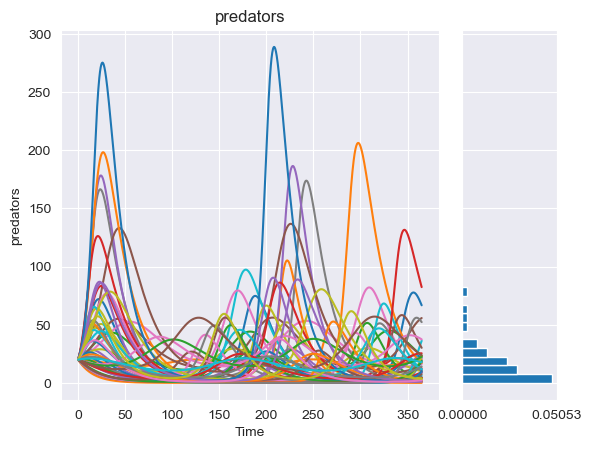

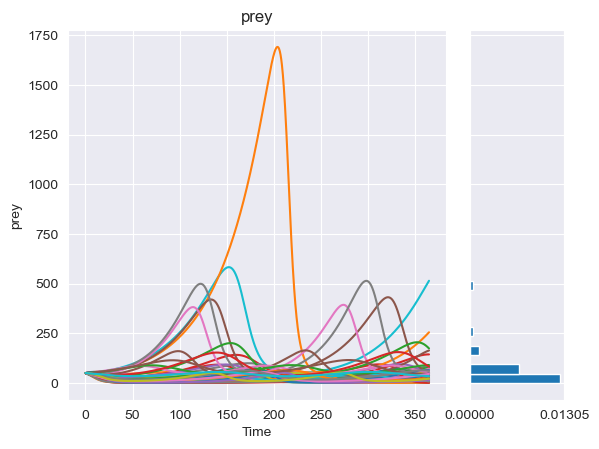

In [21]:
py_model = Model("predatorPrey", function=PredPrey)

py_model.uncertainties = [
                RealParameter('prey_birth_rate', 0.015, 0.035), 
                 RealParameter('predation_rate', 0.0005, 0.003), 
                 RealParameter("predator_efficiency", 0.0001, 0.004), 
                 RealParameter("predator_loss_rate",0.04, 0.08)]
# TimeSeriesOutcome('TIME', variable_name='TIME')
# not scalarOutcome????
py_model.outcomes = [ TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome("prey")]

with SequentialEvaluator(py_model) as evaluator:
    experiments, py_outcomes = evaluator.perform_experiments(scenarios=50)

ema_logging.log_to_stderr(ema_logging.INFO)
# 
# print(py_outcomes)

py_outcomes_dict = {}

for key, value in py_outcomes.items():
    new_value = value.reshape((value.shape[0] * value.shape[1]), value.shape[2])
    py_outcomes_dict[key] = new_value
for outcome in py_outcomes_dict.keys():
    if outcome != 'TIME':
        lines(experiments, py_outcomes_dict, outcomes_to_show=outcome,
              density=plotting_util.Density.HIST)
plt.show()

# SD Model

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments

  0%|                                                   | 0/50 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially

100%|██████████████████████████████████████████| 50/50 [00:01<00:00, 37.26it/s]
[MainProcess/INFO] experiments finished
  0%|                                                   | 0/50 [07:47<?, ?it/s]


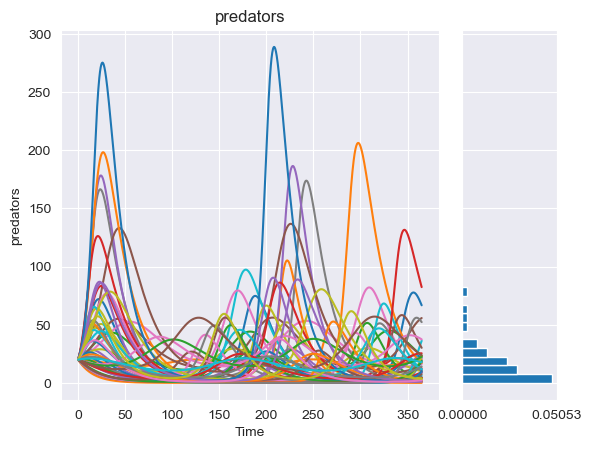

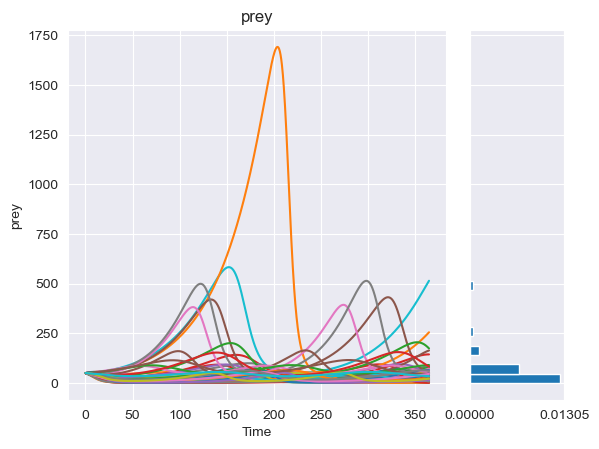

In [28]:
# Define uncertainties and outcomes
sd_model = PysdModel("predatorPrey", mdl_file="./model/PredPrey.mdl")

sd_model.uncertainties = [
                RealParameter('prey_birth_rate', 0.015, 0.035, variable_name='prey_birth_rate'), 
                 RealParameter('predation_rate', 0.0005, 0.003, variable_name='predation_rate'), 
                 RealParameter("predator_efficiency", 0.0001, 0.004, variable_name='predator_efficiency'), 
                 RealParameter("predator_loss_rate",0.04, 0.08, variable_name='predator_loss_rate')]
# TimeSeriesOutcome('TIME', variable_name='TIME')
# not scalarOutcome????
sd_model.outcomes = [
                  TimeSeriesOutcome('predators', variable_name='predators'),
                  TimeSeriesOutcome("prey", variable_name='prey')]

with SequentialEvaluator(sd_model) as evaluator:
    experiments, sd_outcomes = evaluator.perform_experiments(scenarios=50)

ema_logging.log_to_stderr(ema_logging.INFO)

for outcome in sd_outcomes:
    if outcome != 'TIME':
        lines(experiments, py_outcomes_dict, outcomes_to_show=outcome,
              density=plotting_util.Density.HIST)
plt.show()

# Not Running

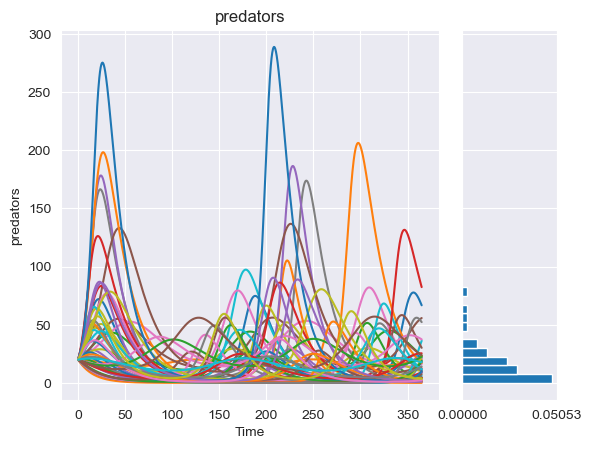

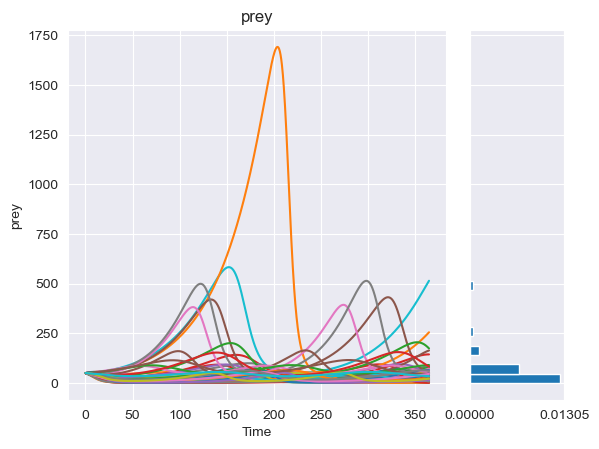

### NetLogo

In [19]:
net_model = NetLogoModel("predprey", wd="./model", model_file="PredPrey.nlogo")
net_model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035), 
                 RealParameter('predation_rate', 0.0005, 0.003), 
                 RealParameter("predator_efficiency", 0.0001, 0.004), 
                 RealParameter("predator_loss_rate",0.04, 0.08 )]

net_model.outcomes = [
    TimeSeriesOutcome("TIME"),
    TimeSeriesOutcome("predators"),
    TimeSeriesOutcome("prey"),
]

# Number of replications and run length
net_model.replications = 10
net_model.run_length = 350

with SequentialEvaluator(net_model) as evaluator:
    experiments, net_outcomes = evaluator.perform_experiments(scenarios=50)





[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
  0%|                                                   | 0/50 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially
/Users/nikhil/anaconda3/lib/python3.11/site-packages/pynetlogo/core.py:186: UserWarning: netlogo home not found
  warnings.warn("netlogo home not found")
[MainProcess/ERROR] No JVM shared library file (libjli.dylib) found. Try setting up the JAVA_HOME environment variable properly.
Traceback (most recent call last):
  File "/Users/nikhil/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/experiment_runner.py", line 92, in run_experiment
    model.run_model(scenario, policy)
  File "/Users/nikhil/anaconda3/lib/python3.11/site-packages/ema_workbench/util/ema_logging.py", line 153, in wrapper
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nikhil/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/model.py", line 

EMAError: Exception in run_model
Caused by: JVMNotFoundException: No JVM shared library file (libjli.dylib) found. Try setting up the JAVA_HOME environment variable properly.

### Excel

In [4]:
# Define uncertainties and outcomes
model = ExcelModel("predatorPrey", wd="./model", model_file="PredPrey.xlsx")

model.uncertainties = [
                RealParameter('prey_birth_rate', 0.015, 0.035), 
                 RealParameter('predation_rate', 0.0005, 0.003), 
                 RealParameter("predator_efficiency", 0.0001, 0.004), 
                 RealParameter("predator_loss_rate",0.04, 0.08 )]
# global outcomes
model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome("prey")]

# name of the sheet
model.default_sheet = "Sheet1"


with SequentialEvaluator(model) as evaluator:
    results = perform_experiments(model, 50, reporting_interval=1, evaluator=evaluator)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
  0%|                                                   | 0/50 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially
[MainProcess/ERROR] win32com
Traceback (most recent call last):
  File "/Users/nikhil/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/experiment_runner.py", line 92, in run_experiment
    model.run_model(scenario, policy)
  File "/Users/nikhil/anaconda3/lib/python3.11/site-packages/ema_workbench/util/ema_logging.py", line 153, in wrapper
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nikhil/anaconda3/lib/python3.11/site-packages/ema_workbench/em_framework/model.py", line 341, in run_model
    super().run_model(scenario, policy)
  File "/Users/nikhil/anaconda3/lib/python3.11/site-packages/ema_workbench/util/ema_logging.py", line 153, in wrapper
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users

EMAError: Exception in run_model
Caused by: ImportError: win32com